In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]
graph.add_edges(graph.edges()[1], graph.edges()[0])

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_49_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fd073ffee40> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(89584)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

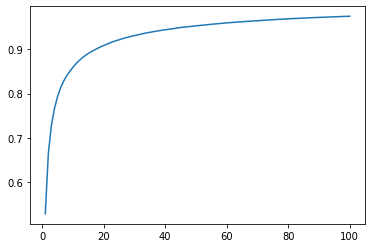

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.5290, 0.6660, 0.7289, 0.7667, 0.7933, 0.8133, 0.8283, 0.8404, 0.8503,
        0.8592, 0.8673, 0.8742, 0.8802, 0.8856, 0.8903, 0.8944, 0.8981, 0.9017,
        0.9053, 0.9081, 0.9111, 0.9140, 0.9166, 0.9190, 0.9211, 0.9233, 0.9252,
        0.9271, 0.9288, 0.9304, 0.9319, 0.9337, 0.9352, 0.9366, 0.9378, 0.9390,
        0.9403, 0.9414, 0.9426, 0.9436, 0.9446, 0.9455, 0.9465, 0.9476, 0.9486,
        0.9494, 0.9502, 0.9508, 0.9516, 0.9524, 0.9531, 0.9538, 0.9545, 0.9552,
        0.9559, 0.9565, 0.9572, 0.9578, 0.9584, 0.9591, 0.9596, 0.9601, 0.9607,
        0.9612, 0.9617, 0.9621, 0.9626, 0.9630, 0.9635, 0.9639, 0.9644, 0.9648,
        0.9653, 0.9658, 0.9662, 0.9667, 0.9671, 0.9674, 0.9678, 0.9682, 0.9686,
        0.9690, 0.9693, 0.9696, 0.9699, 0.9702, 0.9705, 0.9708, 0.9711, 0.9714,
        0.9716, 0.9719, 0.9722, 0.9725, 0.9727, 0.9730, 0.9732, 0.9736, 0.9738,
        0.9740])

In [18]:
percentages.max()

tensor(0.9740)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.68569708, 0.6731663 , 0.66360385, 0.65564564, 0.64903657,
       0.64338256, 0.63839831, 0.63376476, 0.62969174, 0.6259621 ,
       0.62250956, 0.61941247, 0.61665014, 0.61393233, 0.61148084,
       0.60923946, 0.60714471, 0.60511113, 0.60316231, 0.60135967,
       0.59962353, 0.59795477, 0.59637925, 0.59488656, 0.59345966,
       0.59206985, 0.59075237, 0.58948765, 0.5882731 , 0.58705094,
       0.58589143, 0.58484186, 0.58379523, 0.58275998, 0.58178186,
       0.58081839, 0.57987938, 0.57894177, 0.5780035 , 0.57712542,
       0.57630818, 0.57551045, 0.57471509, 0.57394124, 0.57315678,
       0.57240617, 0.57168901, 0.57097331, 0.570262  , 0.56957524,
       0.56891171, 0.56826178, 0.5676172 , 0.56697255, 0.56637121,
       0.56575054, 0.5651305 , 0.56454142, 0.5639626 , 0.56340583,
       0.56284611, 0.56227683, 0.56174502, 0.56120584, 0.56068525,
       0.56019252, 0.55972798, 0.5592309 , 0.55874592, 0.55827522,
       0.5578033 , 0.55734327, 0.5569053 , 0.55644852, 0.55602

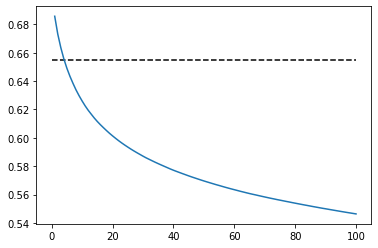

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fd01a2cf8d0> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(91797)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.8766865559806547

In [37]:
max_k = 1000
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  10839,  79872, ...,  14273,    748,  45033],
       [     1, 154949, 100594, ...,  63406, 162351, 156255],
       [     2, 113232,  68589, ..., 105438, 155099,  49773],
       ...,
       [169340,  18094,  61320, ...,  33706,  45789,  99682],
       [169341,  43672,  34227, ..., 110342,  68149,  22862],
       [169342, 127946,  17652, ...,  91346, 164396,  27705]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.7533731119613094

In [40]:
distances

array([[0.9999999 , 0.9915121 , 0.99113756, ..., 0.8683506 , 0.86819077,
        0.86787283],
       [0.99999994, 0.9795114 , 0.9513088 , ..., 0.4228609 , 0.422803  ,
        0.4227019 ],
       [1.        , 0.97691673, 0.9749211 , ..., 0.74151105, 0.74147487,
        0.7414574 ],
       ...,
       [0.9999999 , 0.96663624, 0.9643295 , ..., 0.68821883, 0.6881557 ,
        0.6879867 ],
       [1.0000001 , 0.97906333, 0.9784046 , ..., 0.8234764 , 0.82315344,
        0.8230062 ],
       [0.9999999 , 0.96944284, 0.9420636 , ..., 0.42131683, 0.42130718,
        0.4212672 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

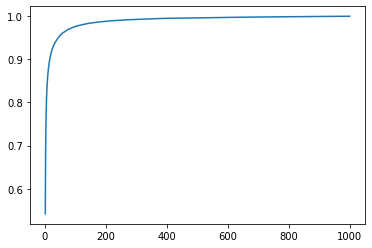

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.5421, 0.6822, 0.7457, 0.7829, 0.8082, 0.8269, 0.8406, 0.8518, 0.8616,
        0.8698, 0.8767, 0.8829, 0.8885, 0.8931, 0.8973, 0.9012, 0.9050, 0.9081,
        0.9113, 0.9142, 0.9169, 0.9194, 0.9215, 0.9237, 0.9258, 0.9276, 0.9293,
        0.9311, 0.9327, 0.9341, 0.9355, 0.9368, 0.9382, 0.9394, 0.9406, 0.9419,
        0.9430, 0.9442, 0.9454, 0.9464, 0.9474, 0.9484, 0.9493, 0.9501, 0.9510,
        0.9520, 0.9529, 0.9538, 0.9546, 0.9553, 0.9560, 0.9568, 0.9575, 0.9583,
        0.9589, 0.9594, 0.9599, 0.9605, 0.9610, 0.9615, 0.9620, 0.9625, 0.9630,
        0.9635, 0.9640, 0.9644, 0.9649, 0.9654, 0.9658, 0.9662, 0.9667, 0.9670,
        0.9673, 0.9678, 0.9682, 0.9685, 0.9690, 0.9694, 0.9696, 0.9699, 0.9702,
        0.9706, 0.9709, 0.9712, 0.9715, 0.9717, 0.9720, 0.9723, 0.9727, 0.9730,
        0.9733, 0.9736, 0.9739, 0.9741, 0.9745, 0.9747, 0.9749, 0.9752, 0.9754,
        0.9756, 0.9758, 0.9760, 0.9762, 0.9765, 0.9766, 0.9769, 0.9771, 0.9772,
        0.9773, 0.9775, 0.9777, 0.9778, 

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.68443337, 0.67130321, 0.661726  , 0.65349321, 0.64655994,
       0.64068685, 0.6357199 , 0.63112367, 0.62722666, 0.6232717 ,
       0.61976419, 0.61664147, 0.61381884, 0.61100505, 0.60839952,
       0.6061374 , 0.60400767, 0.60195809, 0.59993653, 0.59808495,
       0.59640605, 0.59474987, 0.59315734, 0.59159344, 0.5901908 ,
       0.5887516 , 0.58746471, 0.58616957, 0.58490613, 0.58369089,
       0.5825491 , 0.58140708, 0.58038025, 0.57931726, 0.5783275 ,
       0.57737009, 0.57636309, 0.57543068, 0.5745361 , 0.57363989,
       0.57277717, 0.57195807, 0.57112666, 0.57032473, 0.56953757,
       0.56879657, 0.56805268, 0.5672966 , 0.5666032 , 0.5659184 ,
       0.56523614, 0.56457445, 0.56393438, 0.56326028, 0.56262765,
       0.56200223, 0.56138217, 0.56081729, 0.56024744, 0.55967189,
       0.55911424, 0.55854266, 0.55798436, 0.55745292, 0.55693174,
       0.5564073 , 0.55587772, 0.55536874, 0.55489284, 0.55440885,
       0.5539399 , 0.55345134, 0.55296072, 0.55249381, 0.55205

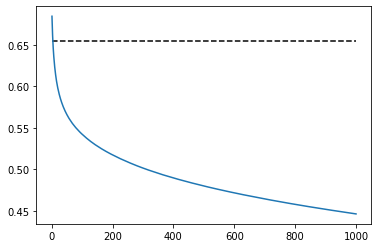

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

### Percentage of same class neighbors by angular section

In [51]:
distance_list = np.linspace(0.99, 0.5, 50)
distance_list

array([0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89,
       0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79, 0.78,
       0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68, 0.67,
       0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57, 0.56,
       0.55, 0.54, 0.53, 0.52, 0.51, 0.5 ])

In [52]:
perc_section_same_class = np.zeros(distance_list.shape)
n_section_neighbors = np.zeros(distance_list.shape)
n_section_same_class = np.zeros(distance_list.shape)
for idx, dist in enumerate(distance_list):
    n_section_neighbors[idx] = (distances > dist)[:, 1:].sum()
    n_section_same_class[idx] = (is_same_class * (distances > dist)[:, 1:]).sum()
    perc_section_same_class[idx] = n_section_same_class[idx] / n_section_neighbors[idx]
perc_section_same_class

array([0.69892172, 0.7590794 , 0.77060171, 0.7705282 , 0.76424083,
       0.75681953, 0.75037586, 0.74443484, 0.73909553, 0.73380314,
       0.72900507, 0.72433102, 0.71999814, 0.71612615, 0.71268193,
       0.70973317, 0.70656073, 0.703183  , 0.69950238, 0.69560672,
       0.6913472 , 0.686793  , 0.68202379, 0.67698473, 0.67177951,
       0.66653873, 0.66125265, 0.65596067, 0.65069019, 0.64542856,
       0.64018195, 0.6349299 , 0.62972802, 0.62454599, 0.61938812,
       0.61425724, 0.60914062, 0.60401379, 0.5988942 , 0.59368148,
       0.58833773, 0.58282535, 0.57711396, 0.57118467, 0.56491707,
       0.55827859, 0.55118887, 0.54359869, 0.53547722, 0.52670195])

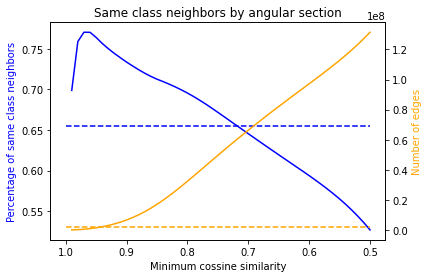

In [53]:
fig, ax1 = plt.subplots()
ax1.set_title('Same class neighbors by angular section')
ax1.set_ylabel('Percentage of same class neighbors', color='blue')
ax1.set_xlabel('Minimum cossine similarity')
ax1.invert_xaxis()
ax1.plot(distance_list, perc_section_same_class, color='blue')
ax1.hlines(0.6551, 1, 0.5, color='blue', ls='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of edges', color='orange')
ax2.plot(distance_list, n_section_neighbors, color='orange')
ax2.hlines(graph.edges()[0].shape[0], 1, 0.5, color='orange', ls='--')

#### Evaluating a single threshold

In [54]:
thresh = 0.8

Number of isolated nodes

In [55]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 0).sum()

2924

Number of connected nodes

In [56]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 1).sum()

166419

Number of edges

In [57]:
((distances > thresh)[:, 1:] * 1).sum()

32401021

Number of edges in the graph - Undirected

In [58]:
graph.edges()[0].shape[0]

2332486

Degree distribution

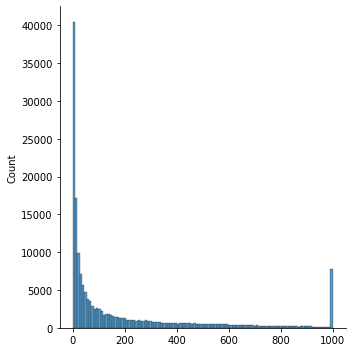

In [59]:
degree_dist = ((distances > thresh)[:, 1:] * 1).sum(axis=1)
sns.displot(degree_dist)

## Inner Product

In [60]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [61]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [62]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fd01a012060> >

In [63]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [64]:
distances, indices = index_ip.search(embeddings, 2)

In [65]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(9609)

In [66]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [67]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

3.7534185780136795

In [68]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [69]:
indices

array([[  8856, 113109,  29771, ...,  93782,  12907, 149571],
       [100594, 154949,      1, ..., 160811,  88752,  61070],
       [ 76500, 138975, 161582, ...,   5211,  68345,  63944],
       ...,
       [ 14350,  77402, 169340, ...,  11018, 151621, 132029],
       [  8856,  29771, 113109, ..., 152633,   6347,  57070],
       [ 13442,  31444,  10353, ..., 157709,  35377,  20914]])

In [70]:
sum(embeddings[0] * embeddings[411])

6.506837156027359

In [71]:
distances

array([[13.507845 , 13.236922 , 12.850359 , ...,  8.968251 ,  8.952421 ,
         8.948148 ],
       [26.376534 , 22.115255 , 21.931519 , ..., 12.22367  , 12.218848 ,
        12.206434 ],
       [18.26006  , 18.039898 , 18.003796 , ..., 14.16149  , 14.152208 ,
        14.122245 ],
       ...,
       [12.947245 , 12.557326 , 12.385193 , ..., 10.631097 , 10.627673 ,
        10.61597  ],
       [13.892276 , 13.279031 , 13.215905 , ..., 10.231684 , 10.2261915,
        10.208877 ],
       [34.542137 , 34.157738 , 34.113266 , ..., 16.36047  , 16.27111  ,
        16.261951 ]], dtype=float32)

In [72]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [73]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

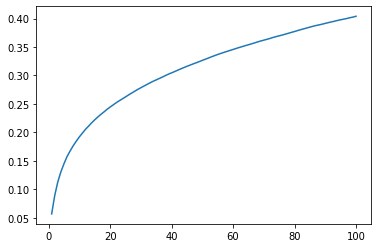

In [74]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [75]:
percentages

tensor([0.0567, 0.0893, 0.1132, 0.1307, 0.1448, 0.1575, 0.1673, 0.1765, 0.1845,
        0.1920, 0.1988, 0.2054, 0.2110, 0.2168, 0.2220, 0.2270, 0.2316, 0.2359,
        0.2405, 0.2445, 0.2483, 0.2521, 0.2556, 0.2589, 0.2623, 0.2658, 0.2690,
        0.2723, 0.2755, 0.2784, 0.2814, 0.2842, 0.2871, 0.2898, 0.2922, 0.2947,
        0.2972, 0.2998, 0.3024, 0.3046, 0.3069, 0.3093, 0.3116, 0.3139, 0.3161,
        0.3182, 0.3203, 0.3223, 0.3244, 0.3265, 0.3286, 0.3307, 0.3329, 0.3349,
        0.3369, 0.3387, 0.3405, 0.3423, 0.3440, 0.3457, 0.3475, 0.3492, 0.3508,
        0.3524, 0.3540, 0.3556, 0.3572, 0.3590, 0.3606, 0.3620, 0.3635, 0.3650,
        0.3668, 0.3683, 0.3697, 0.3711, 0.3726, 0.3742, 0.3758, 0.3773, 0.3789,
        0.3805, 0.3820, 0.3835, 0.3850, 0.3864, 0.3878, 0.3889, 0.3902, 0.3915,
        0.3929, 0.3942, 0.3953, 0.3967, 0.3979, 0.3990, 0.4001, 0.4015, 0.4026,
        0.4041])

### Percentage of same class neighbors by neighborhood size

In [76]:
ind_labels = label_transform(indices)

In [77]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [78]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [79]:
perc_same_class = n_same_class / n_total

In [80]:
perc_same_class

array([0.47923445, 0.47221025, 0.46789849, 0.4636566 , 0.45969895,
       0.45630958, 0.45343221, 0.450928  , 0.44892582, 0.44695086,
       0.44514334, 0.44370843, 0.44227987, 0.44094657, 0.43979143,
       0.43862272, 0.43748799, 0.43648066, 0.43548115, 0.43462086,
       0.43376123, 0.43289279, 0.43213273, 0.43143182, 0.43075793,
       0.43014405, 0.42952775, 0.42890191, 0.42827442, 0.42763031,
       0.42698166, 0.42640067, 0.42587207, 0.42535338, 0.424865  ,
       0.42440261, 0.42390584, 0.42343817, 0.42297858, 0.42252056,
       0.42212536, 0.42169373, 0.42131197, 0.4209536 , 0.42058281,
       0.42017642, 0.41983656, 0.41948971, 0.41915581, 0.4188133 ,
       0.41846615, 0.41811839, 0.41778554, 0.41746698, 0.4171351 ,
       0.41685134, 0.4165474 , 0.41622044, 0.41591637, 0.41563247,
       0.41532507, 0.41503978, 0.41475894, 0.4144629 , 0.41419241,
       0.41392734, 0.41368252, 0.41343987, 0.41317669, 0.41292516,
       0.41267091, 0.41242249, 0.4121651 , 0.41192639, 0.41168

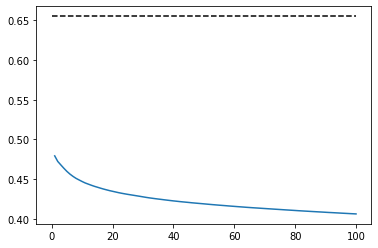

In [81]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [82]:
pca = PCA(n_components=2)

In [83]:
pca.fit(embeddings)

PCA(n_components=2)

In [84]:
emb_2d = pca.transform(embeddings)

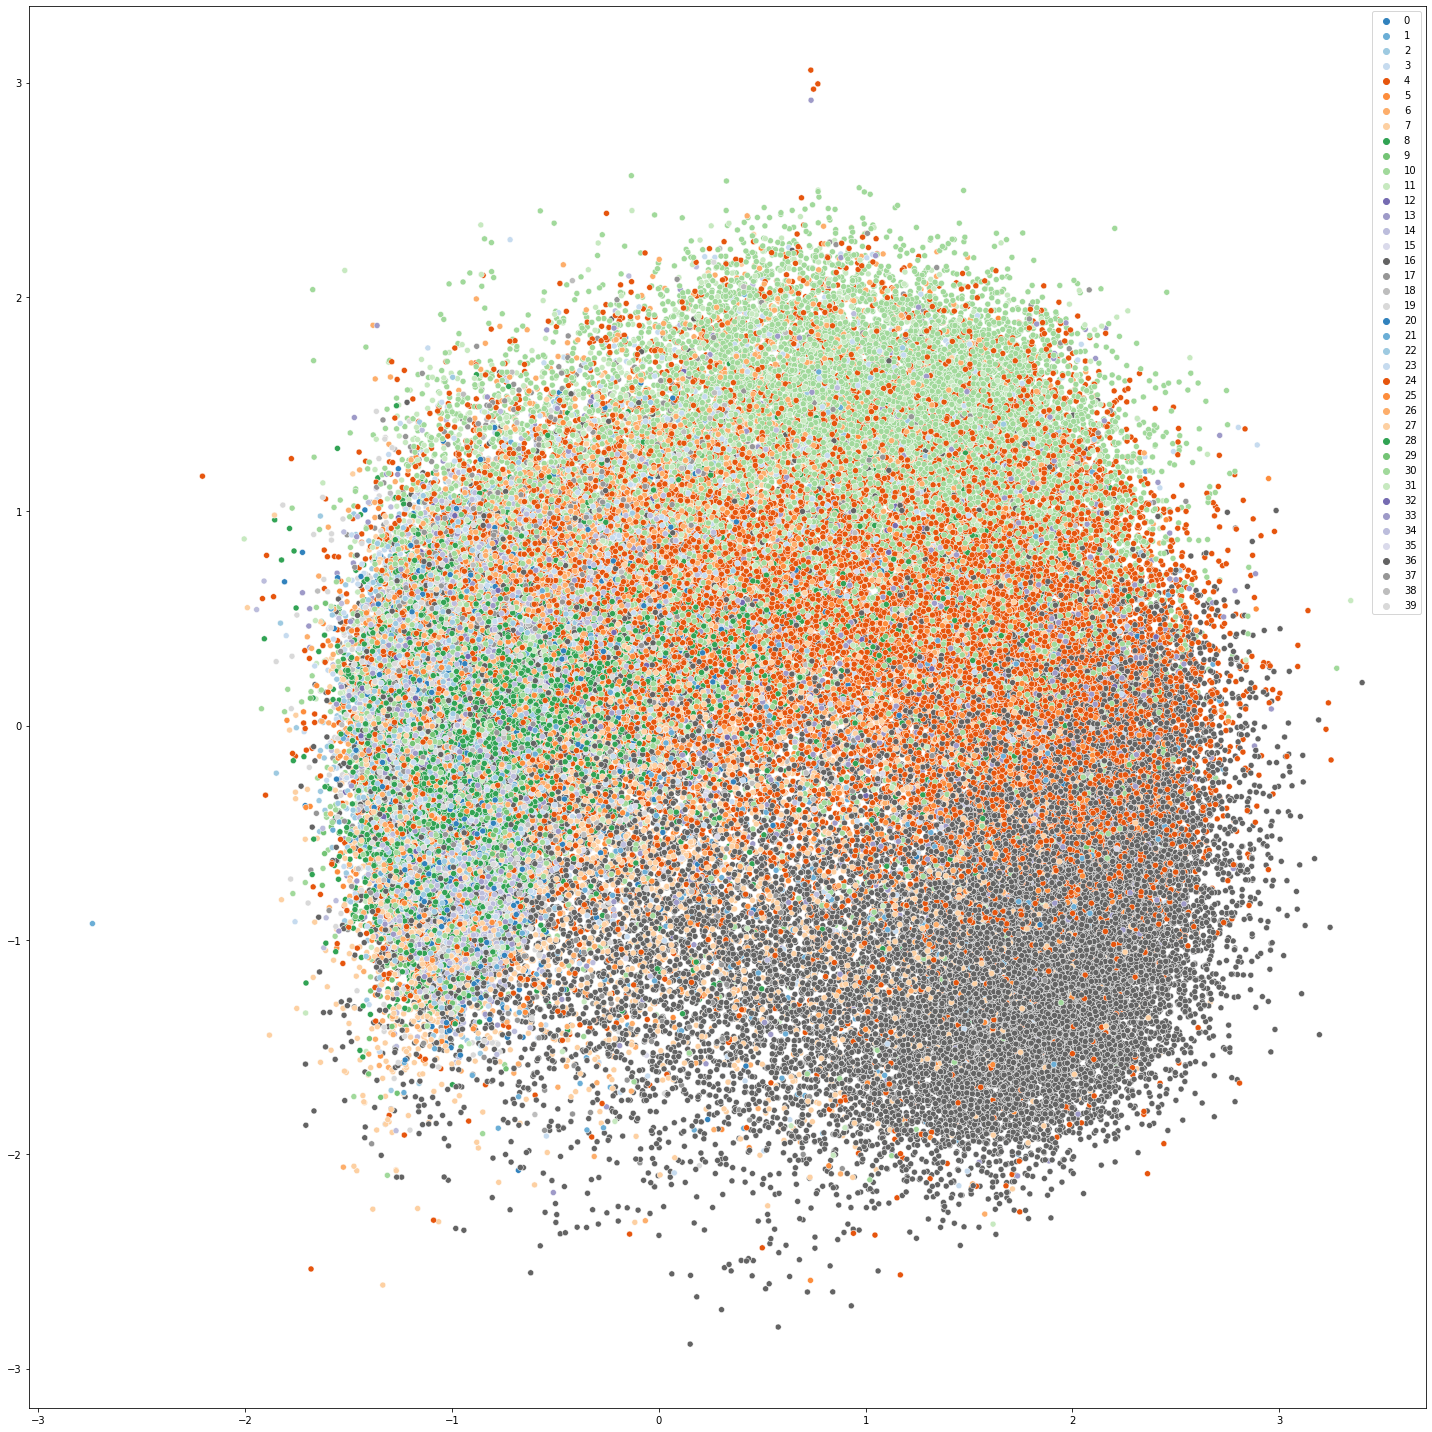

In [85]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [86]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

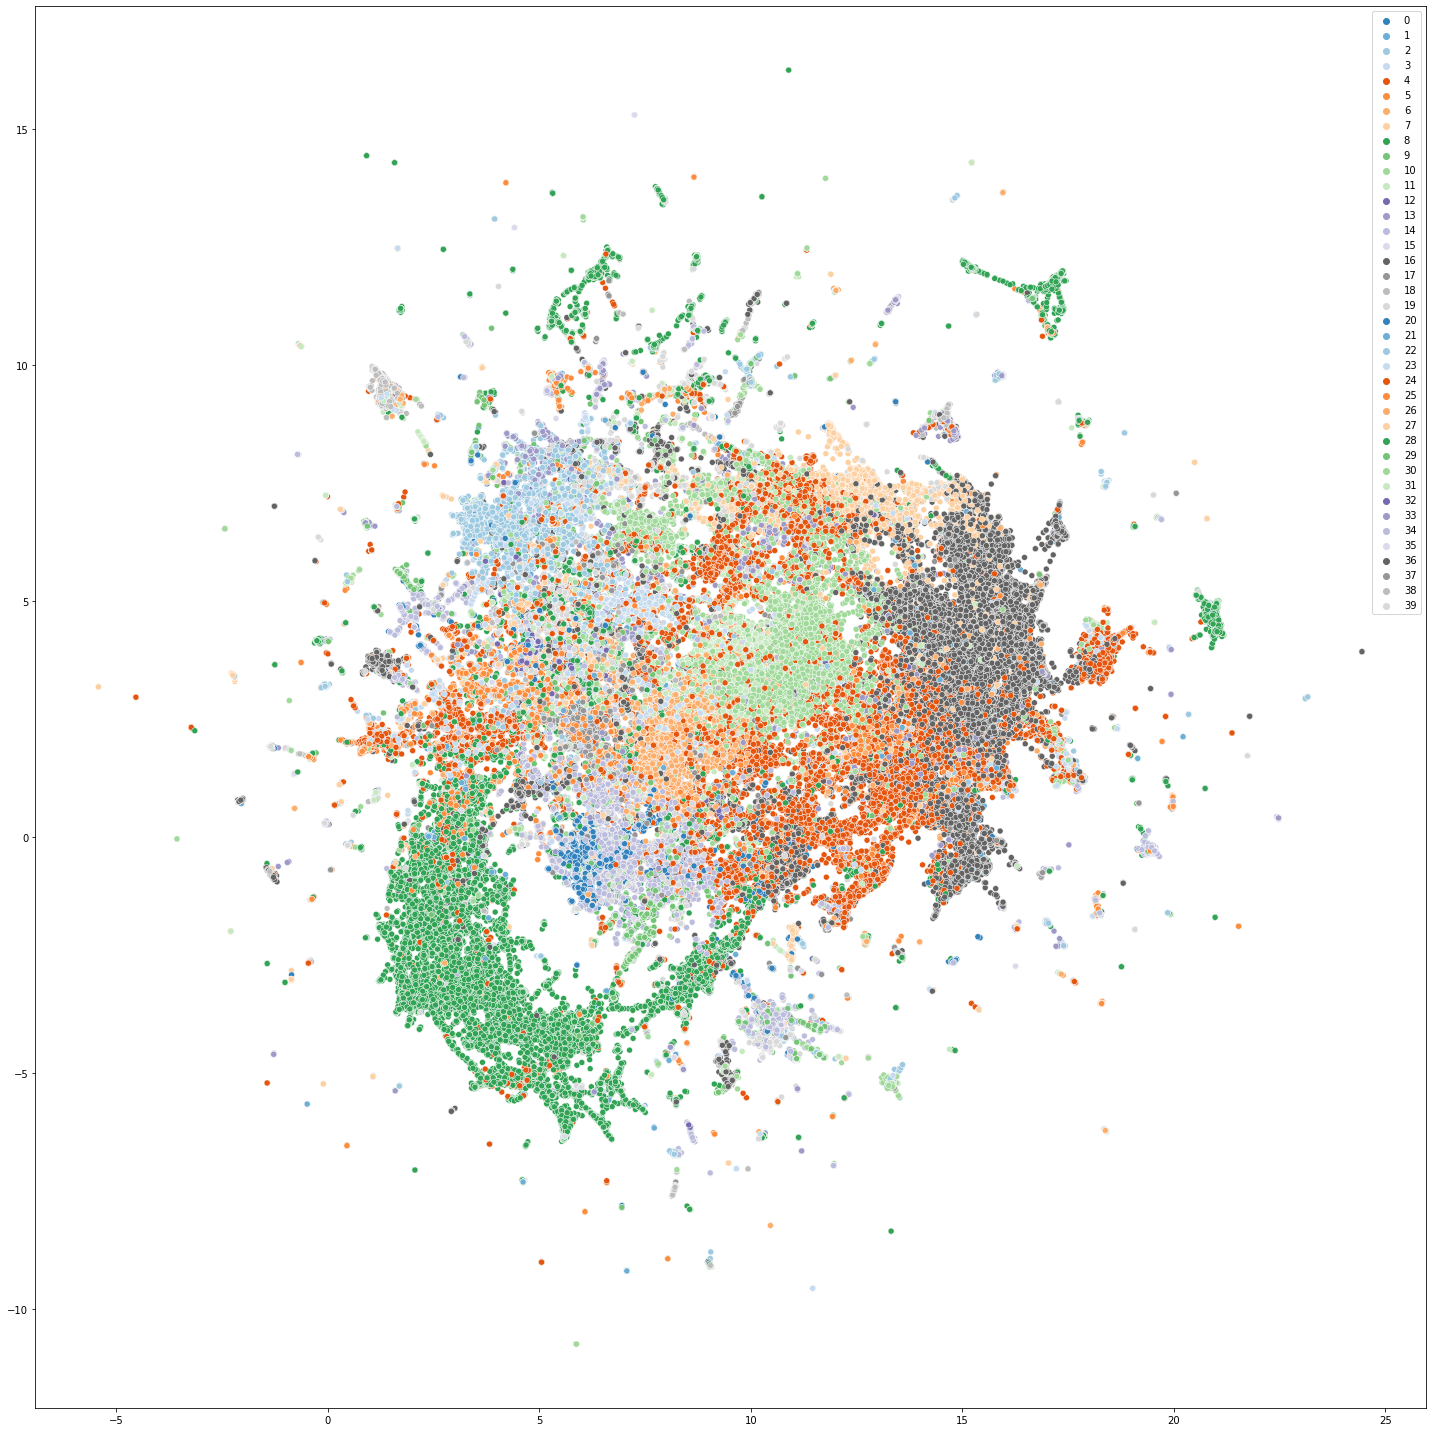

In [87]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [88]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

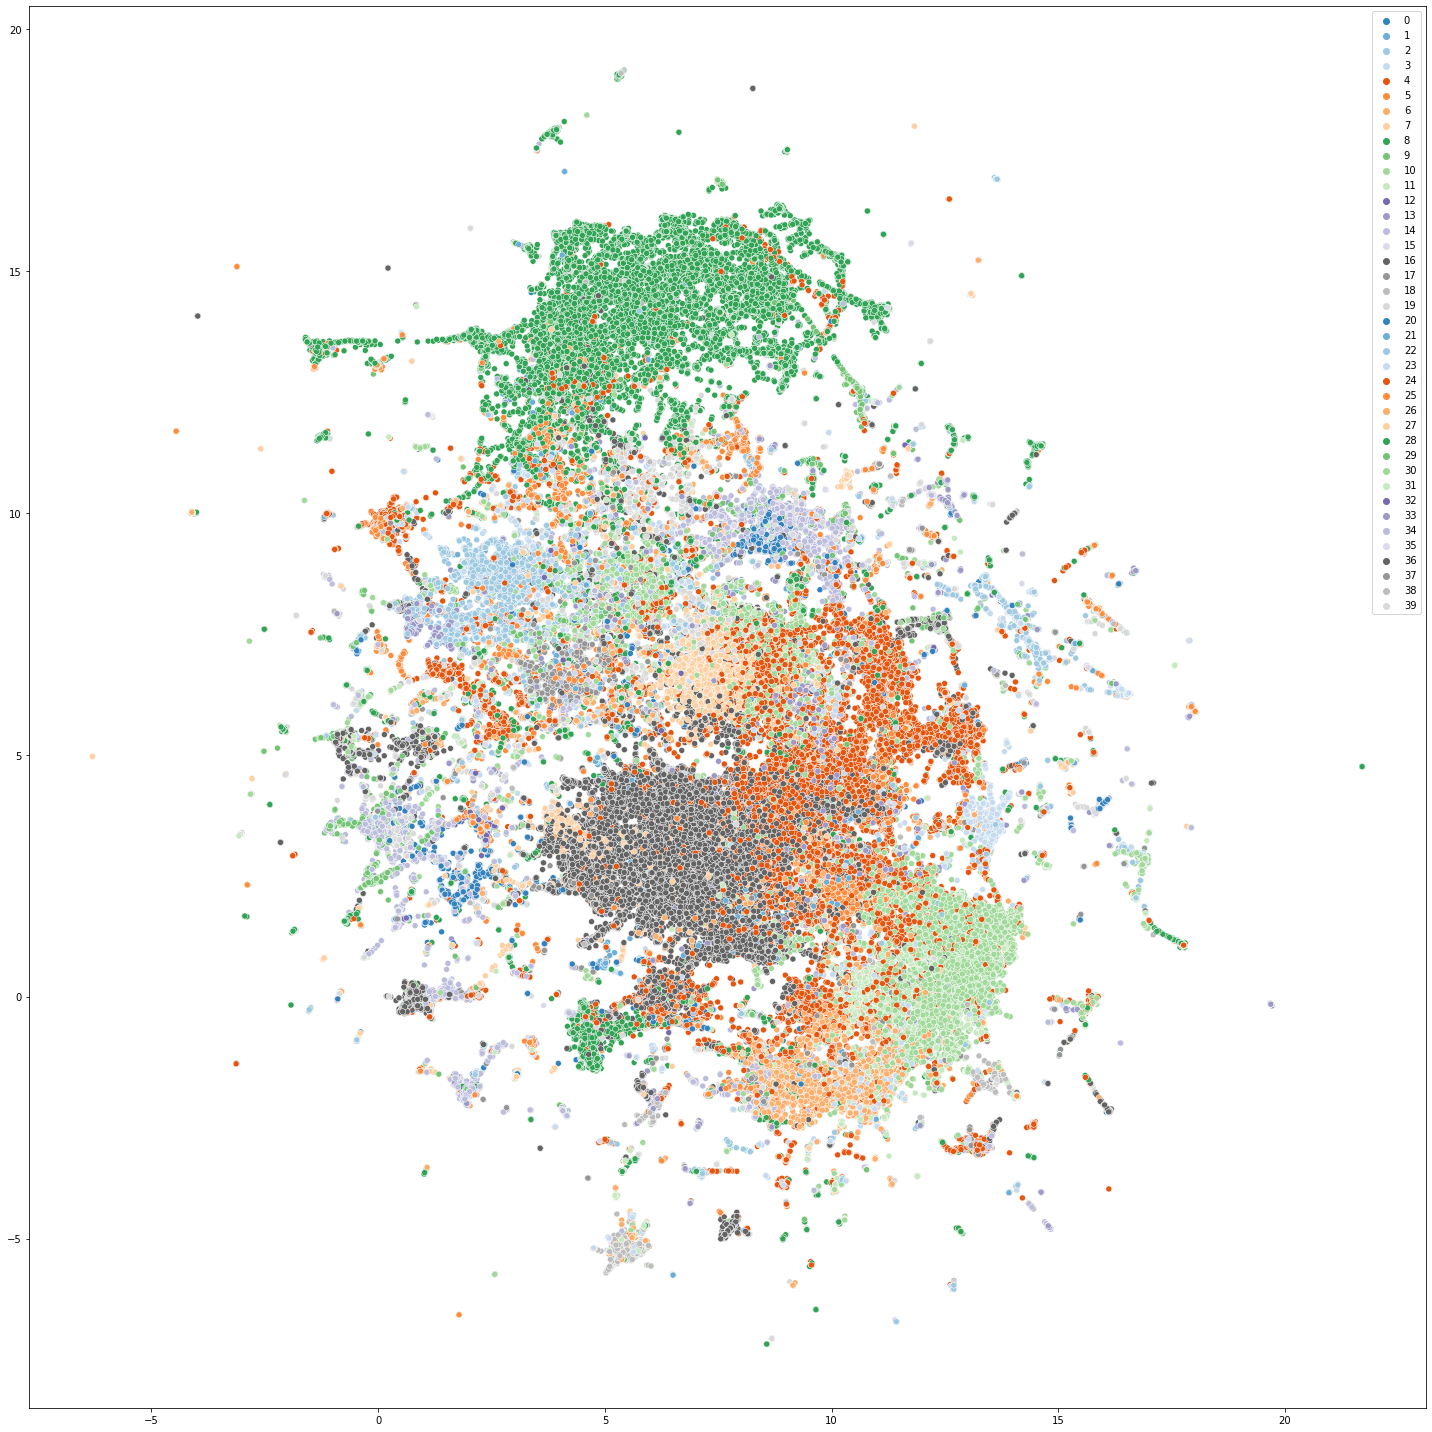

In [89]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()